In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

## Create Data

In [2]:
def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = 3*(1-np.cos(q)) + p**2 # pendulum hamiltonian
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0,3], timescale=15, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    
    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2.-1
    if radius is None:
        radius = np.random.rand() + 1.3 # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )
        
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])
    
    # get vector directions
    dydt = [dynamics_fn(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [3]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Plot Data

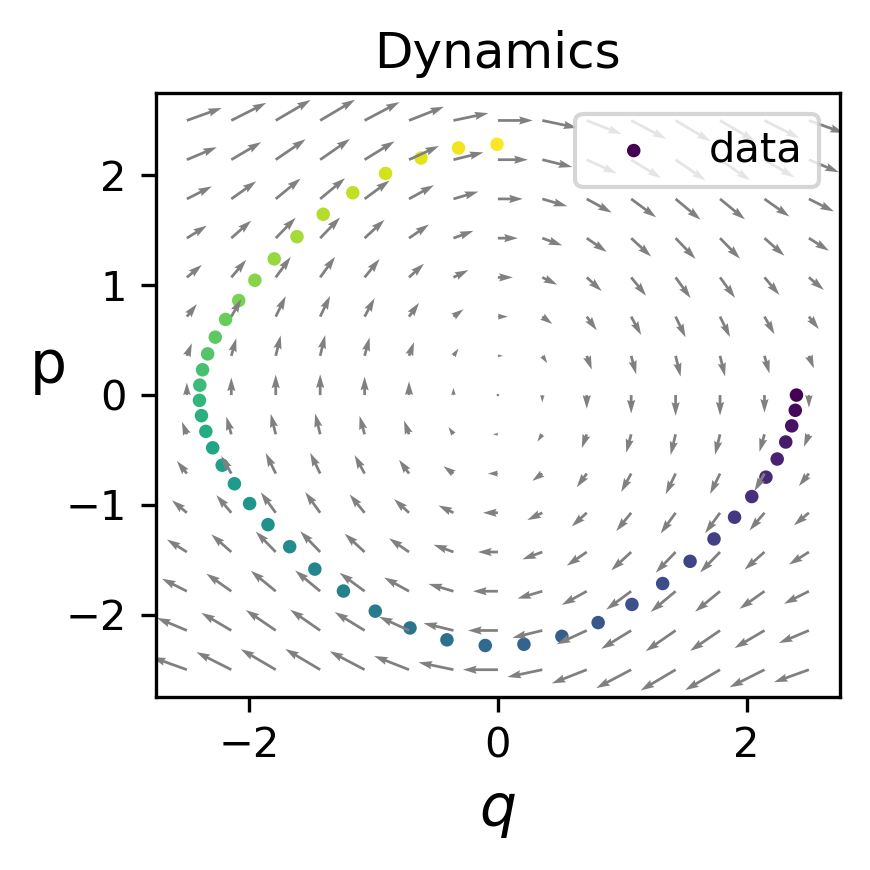

In [4]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(t_span=[0,3], radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=5, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()

## Lern Network

In [5]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
qp = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
dqp = torch.Tensor(data['dx'])

qp_test = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
dqp_test = torch.Tensor(data['test_dx'])

In [7]:
q_p = torch.stack([torch.tensor(x, requires_grad=True), torch.tensor(y, requires_grad=True)], dim=1)
dq_dp = torch.stack([torch.tensor(dx[0], requires_grad=True), torch.tensor(dy[0], requires_grad=True)], dim=1) 

In [8]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

def train(model, optimizer, loss, x, dx, x_test, dx_test, epochs):
    for step in range(epochs):
        model.train()
        optimizer.zero_grad()
        x_pred = model(x)
        loss_val = loss(x_pred, dx)
        loss_val.backward()
        optimizer.step()

        # test loss
        model.eval()
        with torch.no_grad():
            x_pred_test = model(x_test)
            loss_val_test = loss(x_pred_test, dx_test)
        
        print(f"Epoch {step+1}/{epochs} --- Train-Loss: {round(loss_val.item(), 3)}; Test-Loss: {round(loss_val_test.item(), 3)}")

train(model, optimizer, loss, qp, dqp, qp_test, dqp_test, 100)

Epoch 1/100 --- Train-Loss: 6.824; Test-Loss: 5.021
Epoch 2/100 --- Train-Loss: 5.174; Test-Loss: 3.632
Epoch 3/100 --- Train-Loss: 3.778; Test-Loss: 2.516
Epoch 4/100 --- Train-Loss: 2.638; Test-Loss: 1.663
Epoch 5/100 --- Train-Loss: 1.746; Test-Loss: 1.054
Epoch 6/100 --- Train-Loss: 1.089; Test-Loss: 0.66
Epoch 7/100 --- Train-Loss: 0.641; Test-Loss: 0.447
Epoch 8/100 --- Train-Loss: 0.375; Test-Loss: 0.377
Epoch 9/100 --- Train-Loss: 0.255; Test-Loss: 0.41
Epoch 10/100 --- Train-Loss: 0.245; Test-Loss: 0.505
Epoch 11/100 --- Train-Loss: 0.307; Test-Loss: 0.626
Epoch 12/100 --- Train-Loss: 0.405; Test-Loss: 0.745
Epoch 13/100 --- Train-Loss: 0.509; Test-Loss: 0.839
Epoch 14/100 --- Train-Loss: 0.596; Test-Loss: 0.897
Epoch 15/100 --- Train-Loss: 0.654; Test-Loss: 0.917
Epoch 16/100 --- Train-Loss: 0.678; Test-Loss: 0.901
Epoch 17/100 --- Train-Loss: 0.669; Test-Loss: 0.855
Epoch 18/100 --- Train-Loss: 0.633; Test-Loss: 0.789
Epoch 19/100 --- Train-Loss: 0.577; Test-Loss: 0.709
Epoc

In [9]:
model_HNN = MLP()
optimizer = torch.optim.Adam(model_HNN.parameters(), lr=1e-3)
loss = nn.MSELoss()

def train(model, optimizer, loss, x, dx, epochs):
    
    for step in range(epochs):
        model.train()
        optimizer.zero_grad()
        H = model(x)
        a, b = H.split(1,1)


        x_field = torch.autograd.grad(a.sum(), x, create_graph=True)[0] # gradients for field
        dH = torch.zeros_like(x_field)
        dH.T[0] = x_field.T[1]
        dH.T[1] = -x_field.T[0]

        loss_val = loss(dH, dx)
        loss_val.backward()
        optimizer.step()

        """# test loss
        model.eval()
        x_pred_test = model(x_test)
        x_field = torch.autograd.grad(x_pred_test.sum(), x_test, create_graph=True)[0] # gradients for conservative field
        dH = torch.zeros_like(x_field)
        dH.T[0] = x_field.T[1]
        dH.T[1] = -x_field.T[0]

        loss_val_test = loss(dH, dx_test)"""
        
        print(f"Epoch {step+1}/{epochs} --- Train-Loss: {round(loss_val.item(), 3)}")#; Test-Loss: {round(loss_val_test.item(), 3)}")

train(model_HNN.double(), optimizer, loss, q_p, dq_dp, 100)

Epoch 1/100 --- Train-Loss: 6.746
Epoch 2/100 --- Train-Loss: 6.406
Epoch 3/100 --- Train-Loss: 6.082
Epoch 4/100 --- Train-Loss: 5.77
Epoch 5/100 --- Train-Loss: 5.47
Epoch 6/100 --- Train-Loss: 5.178
Epoch 7/100 --- Train-Loss: 4.895
Epoch 8/100 --- Train-Loss: 4.62
Epoch 9/100 --- Train-Loss: 4.353
Epoch 10/100 --- Train-Loss: 4.094
Epoch 11/100 --- Train-Loss: 3.843
Epoch 12/100 --- Train-Loss: 3.6
Epoch 13/100 --- Train-Loss: 3.365
Epoch 14/100 --- Train-Loss: 3.138
Epoch 15/100 --- Train-Loss: 2.918
Epoch 16/100 --- Train-Loss: 2.706
Epoch 17/100 --- Train-Loss: 2.5
Epoch 18/100 --- Train-Loss: 2.301
Epoch 19/100 --- Train-Loss: 2.109
Epoch 20/100 --- Train-Loss: 1.924
Epoch 21/100 --- Train-Loss: 1.747
Epoch 22/100 --- Train-Loss: 1.579
Epoch 23/100 --- Train-Loss: 1.422
Epoch 24/100 --- Train-Loss: 1.276
Epoch 25/100 --- Train-Loss: 1.143
Epoch 26/100 --- Train-Loss: 1.024
Epoch 27/100 --- Train-Loss: 0.918
Epoch 28/100 --- Train-Loss: 0.825
Epoch 29/100 --- Train-Loss: 0.745
E

## visualize Results

In [10]:
def calc_traj_HNN(model, q0_p0, t):
    q_p_pred = []

    q_p_pred.append(q0_p0.double())
    for i in range(1, len(t)):
        x = torch.tensor(q_p_pred[-1], requires_grad=True)
        pred = model(x)
        pred = torch.autograd.grad(pred.sum(), x, create_graph=True)[0]
        dH = torch.zeros_like(pred)
        dH.T[0] = pred.T[1]
        dH.T[1] = -pred.T[0]
        dH = dH

        q_p_pred.append(q_p_pred[-1]+dH*(t[1]-t[0]))

    q_p_pred = torch.stack(q_p_pred).detach().numpy()
    return q_p_pred

In [11]:
def calc_traj_NN(model, q0_p0, t):
    q_p_pred = []

    q_p_pred.append(q0_p0.double())
    for i in range(1, len(t)):
        x = torch.tensor(q_p_pred[-1], requires_grad=True)
        pred = model(x)

        q_p_pred.append(q_p_pred[-1]+pred*(t[1]-t[0]))

    q_p_pred = torch.stack(q_p_pred).detach().numpy()
    return q_p_pred

/var/folders/bl/y6h058c51nv6bzn1rdfnwrm40000gn/T/ipykernel_20771/1586231363.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(q_p_pred[-1], requires_grad=True)
/var/folders/bl/y6h058c51nv6bzn1rdfnwrm40000gn/T/ipykernel_20771/1586231363.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_11601pzv9m/croot/pytorch_1681837278807/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  dH.T[0] = pred.T[1]


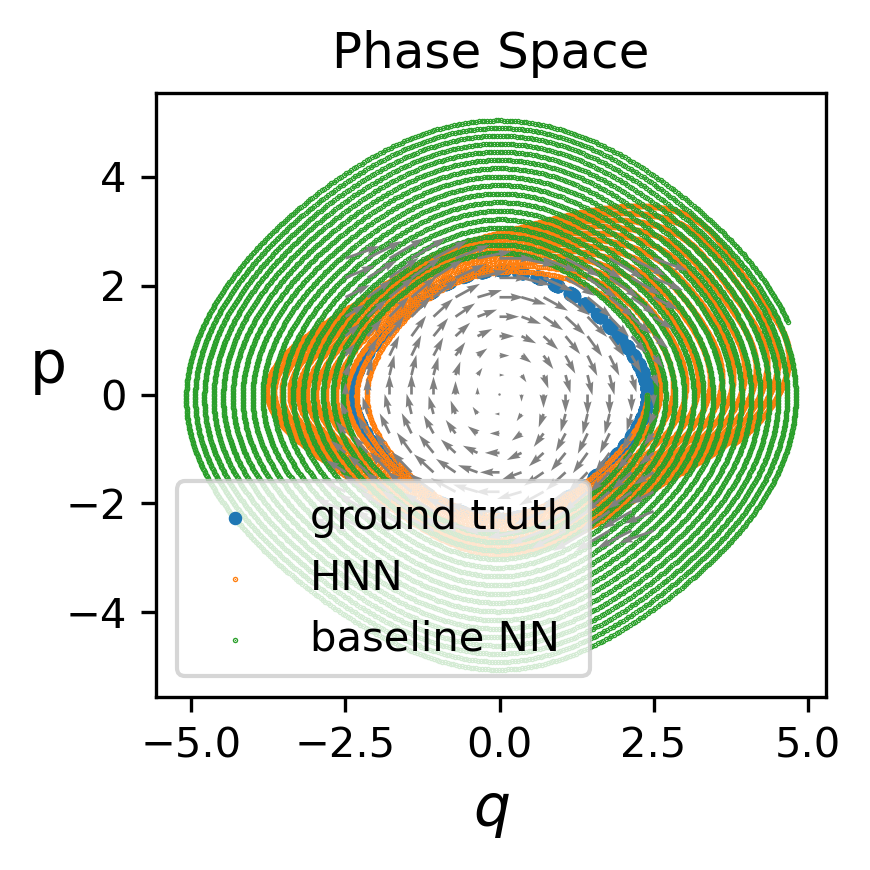

In [12]:
# plot config
q0_p0 = torch.tensor([2.4,0])
t = torch.linspace(0, 100, 10000)

qp_HNN = calc_traj_HNN(model_HNN.double(), q0_p0, t)
qp_NN = calc_traj_NN(model.double(), q0_p0, t)
x, y, dx, dy, t1 = get_trajectory(t_span=[torch.min(t), torch.max(t)], radius=2.4, y0=np.array([2,0]), noise_std=0)

fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

plt.scatter(x,y,s=5, label='ground truth')
plt.scatter(qp_HNN.T[0],qp_HNN.T[1], s=0.1, label='HNN')
plt.scatter(qp_NN.T[0],qp_NN.T[1], s=0.1, label='baseline NN')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Phase Space")
plt.legend()

plt.tight_layout() ; plt.show()